In [1]:
from MyDataset import MyDataset
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
from torch.utils.data import random_split, DataLoader
from torchvision import models
from torch.nn import CrossEntropyLoss, Sequential, Conv2d, ReLU, Dropout, AvgPool2d, Flatten, Linear, MaxPool2d, Conv1d, MaxPool1d, LeakyReLU
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Resize, CenterCrop, Normalize, Lambda
from torch.optim import Adam

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
torch.cuda.empty_cache()
generator = torch.Generator(device=device)

In [8]:
# train_path = ''
# test_path = ''
path = ''

transform = Compose([
    ToImage(),
    #Resize(90),
    Resize((128, 128)),
    ToDtype(torch.float32, scale=True),
])
target_transform = Lambda(lambda y: torch.zeros(32, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))

In [7]:
dataset = MyDataset(path, transform, target_transform)

plt.imshow(dataset[0][0].permute(1, 2, 0).multiply(255).int().cpu())

FileNotFoundError: [Errno 2] No such file or directory: '../../../../Documents/Misc/Data/new'

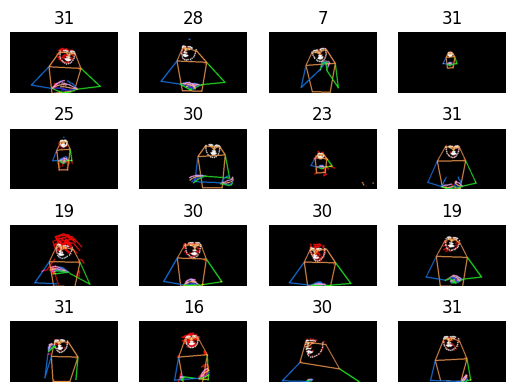

In [5]:
for i, idx in enumerate(np.random.randint(0, len(dataset), 16), 1):
    plt.subplot(4, 4, i)
    image, label = dataset.get_image(idx)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f'{label}')
    plt.axis('off')

In [3]:
def init():
    return Sequential(

        Conv2d(3, 32, 11, 2),
        LeakyReLU(),
        MaxPool2d(3, 2),

        Conv2d(32, 128, 11, 2),
        LeakyReLU(),
        MaxPool2d(3, 2),

        Flatten(),

        Dropout(p=.5),
        Linear(2048, 2048),
        LeakyReLU(),
        Dropout(p=.5),
        Linear(2048, 2048),
        LeakyReLU(),
        Linear(2048, 32)
    )


def train_model(model, loader, criterion, optimizer):
    total_loss = 0
    for samples, labels in loader:
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().cpu()
    return total_loss / (len(loader) * loader.batch_size)


def train_session(model, dataloader, criterion, optimizer, epochs=100):
    model.eval()
    losses = [train_model(model, dataloader, criterion, optimizer) for _ in range(epochs)]
    return losses


def test_model(model, dataloader, top=10):
    model.eval()
    results = None
    true_labels = None
    for samples, labels in dataloader:
        with torch.no_grad():
            output = model(samples)
            res = output.argsort(dim=1, descending=True)[:, :top]
            labels = labels.argmax(dim=1)[:, None]
            if results == None:
                results = res
                true_labels = labels
            else:
                results = torch.vstack((results, res))
                true_labels = torch.vstack((true_labels, labels))
    return results.detach().cpu(), true_labels.detach().cpu()


def process_results(results):
    for col in range(results.shape[1]):
        results[:, col] = results[:, :col+1].any(dim=1)

In [6]:
results = None
true_labels = None
losses = []
for _ in tqdm(range(100)):

    train, test = random_split(dataset, [.5, .5], generator=generator)
    train_loader = DataLoader(train, batch_size=512, shuffle=True, generator=generator)
    test_loader = DataLoader(test, batch_size=512, generator=generator)

    model = init()
    criterion = CrossEntropyLoss(reduction='sum')
    optimizer = Adam(model.parameters(), lr=1e-4)

    losses.append(train_session(model, train_loader, criterion, optimizer, epochs=50))

    res, labels = test_model(model, test_loader, top=10)

    if results == None:
        results = res
        true_labels = labels
    else:
        results = torch.vstack((results, res))
        true_labels = torch.vstack((true_labels, labels))
    del model

100%|███████████████████████████████████████████| 100/100 [10:03:47<00:00, 362.28s/it]


In [95]:
#torch.save(results, 'results.pt')
#torch.save(true_labels, 'true_labels.pt')
#torch.save(L, 'losses.pt')

In [3]:
L = torch.load('losses.pt')
results = torch.load('results.pt')
true_labels = torch.load('true_labels.pt')

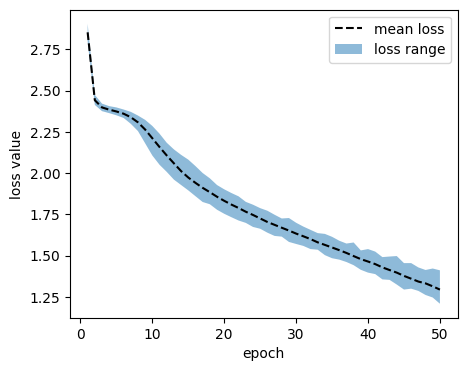

In [4]:
plt.rcParams["figure.figsize"] = (5, 4)
#L = torch.tensor(losses, device='cpu').T

L_min = L.min(dim=1).values
L_max = L.max(dim=1).values
L_mean = L.mean(dim=1)

_, ax = plt.subplots()

ax.plot(range(1, 51), L_mean, 'k--', label='mean loss')
ax.fill_between(range(1, 51), L_max, L_min, alpha=.5, label='loss range')

ax.set(xlabel='epoch', ylabel='loss value')
ax.legend()

plt.savefig('loss.pdf', bbox_inches='tight')

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [39]:
foo, bar = results[:, 0].numpy(), true_labels.numpy().ravel()
foo, bar

(array([31, 31, 10, ..., 19, 19, 23]), array([31, 31, 10, ..., 19, 19, 23]))

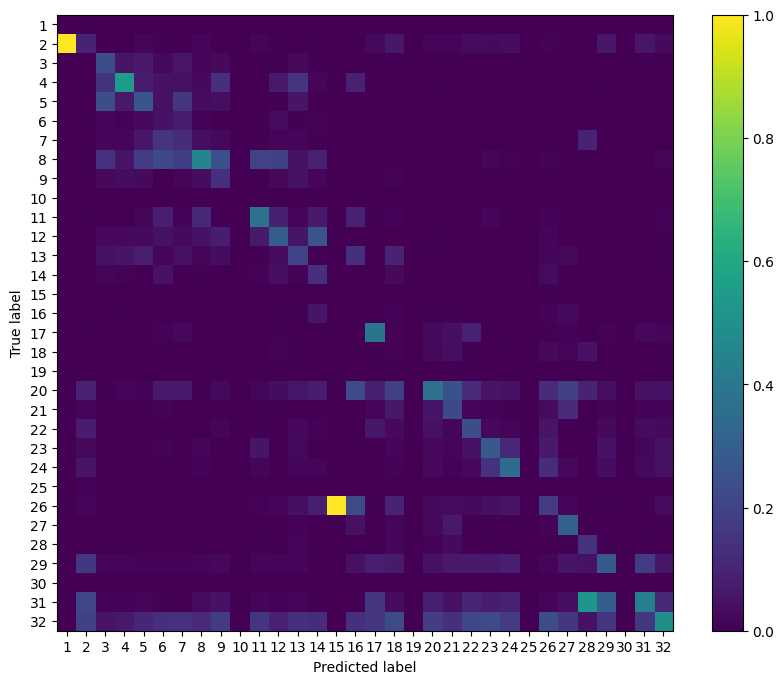

In [10]:
plt.rcParams["figure.figsize"] = (10, 8)
y_true, y_pred = true_labels.numpy().ravel() + 1, results[:, 0].numpy() + 1

cm = confusion_matrix(y_true, y_pred, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='pred', include_values=0)
plt.savefig('cmatrix.pdf', bbox_inches='tight')

In [101]:
results.shape, true_labels.shape

(torch.Size([645400, 10]), torch.Size([645400, 1]))

In [7]:
foo = results == true_labels
process_results(foo)
bar = torch.stack([foo[6454*i: 6454*(i+1), :] for i in range(100)]).float()
M = bar.mean(dim=1)

tensor([0.4274, 0.6169, 0.7331, 0.8090, 0.8614, 0.8973, 0.9220, 0.9396, 0.9527,
        0.9619])

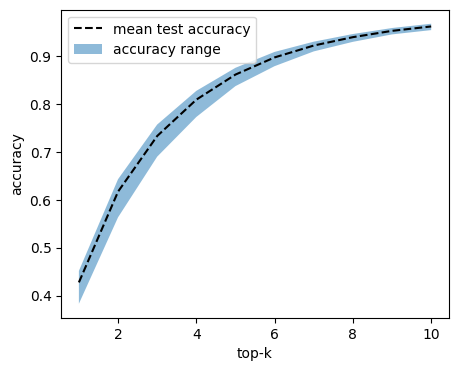

In [8]:
plt.rcParams["figure.figsize"] = (5, 4)

M_min = M.min(dim=0).values
M_max = M.max(dim=0).values
M_mean = M.mean(dim=0)

_, ax = plt.subplots()

ax.plot(range(1, 11), M_mean, 'k--', label='mean test accuracy')
ax.fill_between(range(1, 11), M_max, M_min, alpha=.5, label='accuracy range')

ax.set(xlabel='top-k', ylabel='accuracy')
ax.legend()

plt.savefig('acc.pdf', bbox_inches='tight')
M_mean

In [7]:
model = init()
criterion = CrossEntropyLoss(reduction='sum')
optimizer = Adam(model.parameters(), lr=1e-4)

loader = DataLoader(dataset, batch_size=512, shuffle=True, generator=generator)
#losses = train_session(model, loader, criterion, optimizer, epochs=200)

In [8]:
foo, bar = test_model(model, loader)

In [17]:
(foo == bar).float().mean(dim=0)

tensor([9.8629e-01, 1.3014e-02, 6.1972e-04, 7.7465e-05, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [14]:
#torch.save(model.cpu(), 'model.pt')

In [4]:
model = torch.load('model.pt')
loader = DataLoader(dataset, batch_size=512, shuffle=True, generator=generator)

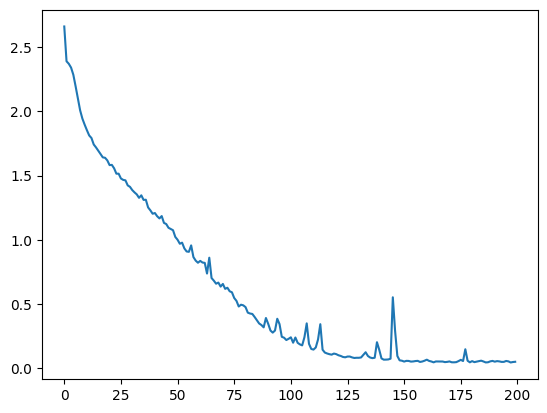

In [15]:
plt.plot(losses)